In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
Ini_date="2022-01-01"
End_date="2022-06-30"

In [3]:
VIX_db = yf.download("^VIX", start=Ini_date, end=End_date)
print(VIX_db[:3])
SP500Fut_db = yf.download("ES=F", start=Ini_date, end=End_date)
print(SP500Fut_db[:3])
SP500_db = yf.download("^GSPC", start=Ini_date, end=End_date)
print(SP500_db[:3])

[*********************100%***********************]  1 of 1 completed
             Open       High        Low  Close  Adj Close  Volume
Date                                                             
2022-01-03  17.60  18.540001  16.559999  16.60      16.60       0
2022-01-04  16.57  17.809999  16.340000  16.91      16.91       0
2022-01-05  17.07  20.170000  16.580000  19.73      19.73       0
[*********************100%***********************]  1 of 1 completed
               Open     High     Low    Close  Adj Close   Volume
Date                                                             
2022-01-03  4771.00  4791.25  4747.5  4786.00    4786.00  1322362
2022-01-04  4785.25  4808.25  4764.5  4784.25    4784.25  1392809
2022-01-05  4783.50  4788.25  4689.5  4692.50    4692.50  1856376
[*********************100%***********************]  1 of 1 completed
                   Open         High          Low        Close    Adj Close  \
Date                                                  

In [4]:
VIX_db=pd.DataFrame(VIX_db['Close'])
SP500Fut_db=pd.DataFrame(SP500Fut_db['Close'])
SP500_db=pd.DataFrame(SP500_db['Close'])

In [5]:
display(VIX_db.head(3))
display(SP500Fut_db.head(3))
display(SP500_db.head(3))

,Close
Date,
2022-01-03,16.60
2022-01-04,16.91
2022-01-05,19.73


,Close
Date,
2022-01-03,4786.00
2022-01-04,4784.25
2022-01-05,4692.50


,Close
Date,
2022-01-03,4796.560059
2022-01-04,4793.540039
2022-01-05,4700.580078


In [6]:
VIX_db.reset_index(inplace=True)
VIX_db = (VIX_db.set_index('Date')
      .reindex(pd.date_range(Ini_date, End_date, freq='D'))
      .rename_axis(['Date'])
      .fillna(method='ffill')
      .dropna()
      .reset_index())

In [7]:
SP500Fut_db.reset_index(inplace=True)
SP500Fut_db = (SP500Fut_db.set_index('Date')
      .reindex(pd.date_range(Ini_date, End_date, freq='D'))
      .rename_axis(['Date'])
      .fillna(method='ffill')
      .dropna()
      .reset_index())

In [8]:
SP500_db.reset_index(inplace=True)
SP500_db = (SP500_db.set_index('Date')
      .reindex(pd.date_range(Ini_date, End_date, freq='D'))
      .rename_axis(['Date'])
      .fillna(method='ffill')
      .dropna()
      .reset_index())

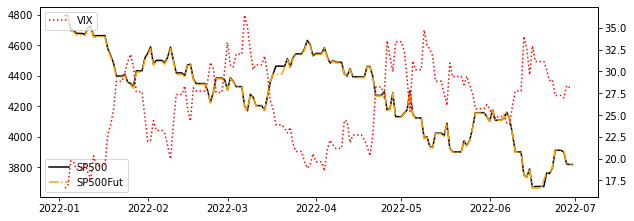

In [9]:
fig, ax1 = plt.subplots(figsize=(10,3.5))
ax2 = ax1.twinx()
ax1.plot(SP500_db['Date'], SP500_db['Close'],label = "SP500", color='black')
ax1.plot(SP500_db['Date'], SP500Fut_db['Close'], label = "SP500Fut",linestyle='dashdot', color='orange')
ax2.plot(SP500_db['Date'], VIX_db['Close'],  label ="VIX",linestyle='dotted', color='red')
ax1.legend(loc='lower left')
ax2.legend(loc='upper left')
plt.show()

In [10]:
MergedData= pd.concat(
    objs=(iDF.set_index('Date') for iDF in (VIX_db, SP500_db, SP500Fut_db)),
    axis=1, 
    join='inner'
).reset_index()
MergedData.columns=['Date','Close_VIX','Close_SP','Close_SPF']
MergedData.head(3)

,Date,Close_VIX,Close_SP,Close_SPF
0,2022-01-03,16.60,4796.560059,4786.00
1,2022-01-04,16.91,4793.540039,4784.25
2,2022-01-05,19.73,4700.580078,4692.50


In [11]:
#MergedData.to_excel("RawData.xlsx")

In [26]:
LimVixUp=30
LimVixDw=20
UPLWret=0.01
Stgy_DF=MergedData.copy()
Stgy_DF['Ret']=Stgy_DF['Close_SP']/Stgy_DF['Close_SP'].shift(1)-1
Stgy_DF['SigVixg30']=(0+(np.sign(Stgy_DF['Close_VIX']-LimVixUp)==1))
Stgy_DF['SigVixs20']=(0+(np.sign(LimVixDw-Stgy_DF['Close_VIX'])==1))
Stgy_DF['SigRetg+5']=np.nan
Stgy_DF['SigRets-5']=np.nan
Stgy_DF['InvestVal']=np.nan
Stgy_DF['InvestOp']=np.nan
Stgy_DF['StrgRet']=0
Stgy_DF['StrgDecitions']=np.nan

In [27]:
print(np.isnan(Stgy_DF.loc[0,'InvestOp']))
print(Stgy_DF.loc[0,'InvestOp'])

True
nan


In [28]:
DecCount=0
SwichBuySell=0
for i in range(len(Stgy_DF)):
  #Strategy return calculation
  
  #print(i>=0)
  #print(Stgy_DF.loc[i,'InvestOp']!=np.nan)
  if i>0:
    #last signal sell
    if  np.isnan(Stgy_DF.loc[i,'InvestOp'])!=True and Stgy_DF.loc[i-1,'StrgDecitions']=='sell':
      Stgy_DF.loc[i,'StrgDecitions']='sell'
      Stgy_DF.loc[i,'InvestVal']=Stgy_DF.loc[i-1,'InvestVal']
      ##print(Stgy_DF[i-1:i+2])
    elif np.isnan(Stgy_DF.loc[i,'InvestOp'])==True and Stgy_DF.loc[i-1,'StrgDecitions']=='sell':
      Stgy_DF.loc[i,'StrgDecitions']='sell'
      Stgy_DF.loc[i,'InvestOp']=Stgy_DF.loc[i-1,'InvestOp']
      Stgy_DF.loc[i,'InvestVal']=Stgy_DF.loc[i-1,'InvestVal']
      ##print(Stgy_DF[i-1:i+2])
    #last signal buy
    if np.isnan(Stgy_DF.loc[i,'InvestOp'])!=True and Stgy_DF.loc[i-1,'StrgDecitions']=='buy':
      Stgy_DF.loc[i,'StrgDecitions']='buy'
      Stgy_DF.loc[i,'InvestVal']=Stgy_DF.loc[i-1,'InvestVal']*(1+Stgy_DF.loc[i,'Ret'])
      ##print(Stgy_DF[i-1:i+2])
    elif np.isnan(Stgy_DF.loc[i,'InvestOp'])==True and Stgy_DF.loc[i-1,'StrgDecitions']=='buy':
      Stgy_DF.loc[i,'StrgDecitions']='buy'
      Stgy_DF.loc[i,'InvestOp']=Stgy_DF.loc[i-1,'InvestOp']
      Stgy_DF.loc[i,'InvestVal']=Stgy_DF.loc[i-1,'InvestVal']*(1+Stgy_DF.loc[i,'Ret'])
      ##print(Stgy_DF[i-1:i+2])

  #Strategy returns calculation
  if np.isnan(Stgy_DF.loc[i,'InvestOp'])==True:
    Stgy_DF.loc[i,'StrgRet']=0
  else:
    Stgy_DF.loc[i,'StrgRet']=Stgy_DF.loc[i,'InvestVal']/Stgy_DF.loc[i,'InvestOp']-1
  ##if i==28:
  ##  print(i)

  if Stgy_DF.loc[i,'SigVixg30']==1:
    #buy
    if DecCount==0:
      Stgy_DF.loc[i,'StrgDecitions']='buy'
      Stgy_DF.loc[i,'InvestVal']=1
      Stgy_DF.loc[i,'InvestOp']=Stgy_DF.loc[i,'InvestVal']
      Stgy_DF.loc[i+1,'InvestOp']=Stgy_DF.loc[i,'InvestVal']
      Stgy_DF.loc[i,'StrgRet']=Stgy_DF.loc[i,'InvestVal']/Stgy_DF.loc[i,'InvestOp']-1
      ##print(Stgy_DF[i-1:i+2])
      DecCount=+1
    elif DecCount>=0 and Stgy_DF.loc[i-1,'StrgDecitions']=='sell':
      Stgy_DF.loc[i,'StrgDecitions']='buy'
      Stgy_DF.loc[i,'InvestOp']=Stgy_DF.loc[i-1,'InvestOp']
      Stgy_DF.loc[i,'InvestVal']=Stgy_DF.loc[i,'InvestOp']
      Stgy_DF.loc[i+1,'InvestOp']=Stgy_DF.loc[i,'InvestVal']
      Stgy_DF.loc[i,'StrgRet']=Stgy_DF.loc[i,'InvestVal']/Stgy_DF.loc[i,'InvestOp']-1
      ##print(Stgy_DF[i-1:i+2])
      DecCount=+1
  
  #Stop loss - Take profit
  if Stgy_DF.loc[i,'StrgRet']<-UPLWret:
    Stgy_DF.loc[i,'SigRets-5']=1
  else:
    Stgy_DF.loc[i,'SigRets-5']=0
  if Stgy_DF.loc[i,'StrgRet']>UPLWret:
    Stgy_DF.loc[i,'SigRetg+5']=1
  else:
    Stgy_DF.loc[i,'SigRetg+5']=0
  
  #print(Stgy_DF.loc[i-1,'StrgDecitions']=='buy')
  if DecCount>0 and (Stgy_DF.loc[i,'SigVixs20']==1 or Stgy_DF.loc[i,'SigRetg+5']==1 or Stgy_DF.loc[i,'SigRets-5']==1):
    #sell
    if Stgy_DF.loc[i-1,'StrgDecitions']=='buy':
      Stgy_DF.loc[i,'StrgDecitions']='sell'
      Stgy_DF.loc[i,'InvestOp']=Stgy_DF.loc[i-1,'InvestOp']
      Stgy_DF.loc[i,'InvestVal']=Stgy_DF.loc[i-1,'InvestVal']*(1+Stgy_DF.loc[i,'Ret'])
      Stgy_DF.loc[i+1,'InvestOp']=Stgy_DF.loc[i,'InvestVal']
      Stgy_DF.loc[i,'StrgRet']=Stgy_DF.loc[i,'InvestVal']/Stgy_DF.loc[i,'InvestOp']-1
      ##print(Stgy_DF[i-1:i+2])
      DecCount=+1
  ##print(Stgy_DF[i-1:i+2])
      
Stgy_DF['InvestVal'].bfill(inplace=True)


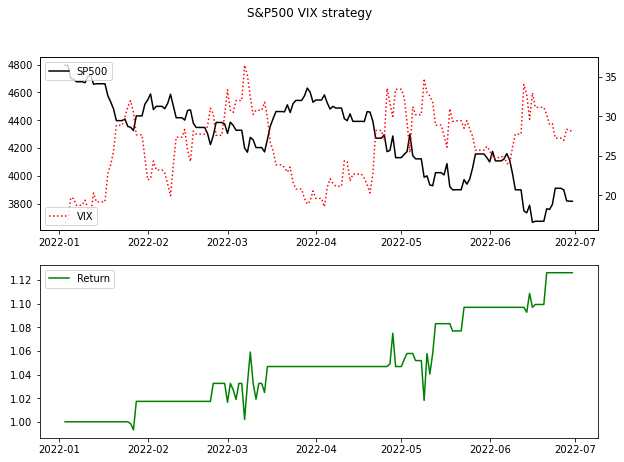

In [29]:
fig, axs = plt.subplots(2,figsize=(10,7))
fig
fig.suptitle('S&P500 VIX strategy')
axs0=axs[0].twinx()
axs[0].plot(Stgy_DF['Date'], Stgy_DF['Close_SP'], color='black',label='SP500') 
axs0.plot(Stgy_DF['Date'], Stgy_DF['Close_VIX'], color='red',label='VIX',linestyle='dotted')
axs[1].plot(Stgy_DF['Date'],Stgy_DF['InvestVal'], color='green',label='Return')
axs[0].legend(loc='upper left')
axs0.legend(loc='lower left')
axs[1].legend(loc='upper left')
plt.show()

In [30]:
Stgy_DF_001=Stgy_DF.copy()

In [25]:
Stgy_DF_003=Stgy_DF.copy()

In [20]:
Stgy_DF_010=Stgy_DF.copy()

In [16]:
Stgy_DF_005=Stgy_DF.copy()

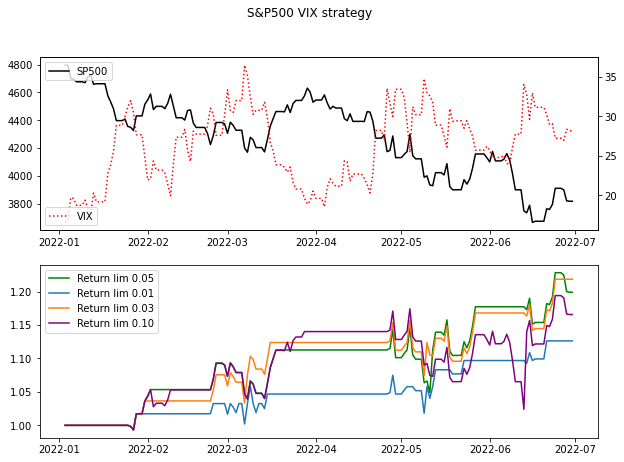

In [34]:
fig, axs = plt.subplots(2,figsize=(10,7))
fig
fig.suptitle('S&P500 VIX strategy')
axs0=axs[0].twinx()
axs[0].plot(Stgy_DF['Date'], Stgy_DF['Close_SP'], color='black',label='SP500') 
axs0.plot(Stgy_DF['Date'], Stgy_DF['Close_VIX'], color='red',label='VIX',linestyle='dotted')
axs[1].plot(Stgy_DF['Date'],Stgy_DF_005['InvestVal'], color='green',label='Return lim 0.05')
axs[1].plot(Stgy_DF['Date'],Stgy_DF_001['InvestVal'], label='Return lim 0.01')
axs[1].plot(Stgy_DF['Date'],Stgy_DF_003['InvestVal'], label='Return lim 0.03')
axs[1].plot(Stgy_DF['Date'],Stgy_DF_010['InvestVal'], color='purple',label='Return lim 0.10')
axs[0].legend(loc='upper left')
axs0.legend(loc='lower left')
axs[1].legend(loc='upper left')
plt.show()

In [35]:
  
# initialize list of lists
data = [['+-0.01', 0.1262], ['+-0.03', 0.2184], ['+-0.05', 0.1990], ['+-0.10', 0.1656]]
  
# Create the pandas DataFrame
df = pd.DataFrame(data, columns=['Range', 'Return'])
  
# print dataframe.
df

,Range,Return
0,+-0.01,0.1262
1,+-0.03,0.2184
2,+-0.05,0.1990
3,+-0.10,0.1656


In [36]:
df.T

,0,1,2,3
Range,+-0.01,+-0.03,+-0.05,+-0.10
Return,0.1262,0.2184,0.199,0.1656
